## Table of Contents:

1. [Introduction](#Introduction)
2. [How expensive the house is getting?](#How-expensive-the-house-is-getting?)
3. [Price distribution](#Price-distribution)
4. [Location correlationship(to cbd)](#Location-correlationship)
5. [So which suburbs should we target?](#So-which-suburbs-should-we-target?)
6. [Conclusion](#Conclusion)

## Introduction <a class="anchor" id="Introduction"></a>
###### With a 1.6 million budget, my client is considering purchasing a single-family home in the Sydney region and wants to be close to CBD. Several questions need to be answered to help her make this decision.
###### 1. Compare to previous years, how many more suburbs becoming unafordable? And where are those suburbs?
###### 2. My client like to know if she has a good amount of options on the market with this budget and requirements.
###### 3. She wants to know if houses close to CBD are necessarily more expensive than those that are not.
###### 4. Suggestions?

##### To answser these questions, there are some sources that I found and utlized in my report:
###### Sales records provided by client.
###### Suburbs information: https://github.com/michalsn/australian-suburbs
###### Shape map of NSW: https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument
###### Train Station Entrance Locations https://opendata.transport.nsw.gov.au/dataset/train-station-entrance-locations

###### Step 1: download data from source using Python.
###### Code:  https://github.com/Tkybluegr/data-analytics/blob/main/sydney_re_extract.ipynb
###### Step 2: Transform data, perform data wrangling add column to_cbd and to_train calculated distance to sydney cbd and sinceest train station respectively. (Using 33.8708 -151.2073 to represent cbd and train stration entrance coodinated downloaded from transport.nsw.gov.au)
###### Code: https://github.com/Tkybluegr/data-analytics/blob/main/sydney_re_transform.ipynb
###### Step 3: Loads data
###### Code: https://github.com/Tkybluegr/data-analytics/blob/main/sydeny_re_load.ipynb

## How expensive the house is getting? <a class="anchor" id="How-expensive-the-house-is-getting"></a>



##### Improt modules and data

In [20]:
import pandas as pd
from pandasql import sqldf

In [21]:
df = pd.read_csv(r'C:\Users\tyler\DA_Tyler\download\www.xxxx.com\all_csv\sydney_data.csv')

##### Use pandasql to run sql query. It can be found that suburbs with average price over 3 millions has increased from 35 (8.2%) to 106 (24.8%).

In [5]:
df_exp = sqldf ('''

WITH enriched AS(
    SELECT suburb
        , price
        , CASE WHEN sold_date BETWEEN '2018-03-30' AND '2019-03-31' THEN '2018-2019'
                WHEN sold_date BETWEEN '2019-03-30' AND '2020-03-31' THEN '2019-2020'
                WHEN sold_date BETWEEN '2020-03-30' AND '2021-03-31' THEN '2020-2021'
                ELSE '2021-current'
                END AS date_cat
    FROM df
    WHERE category = 'detached_house'
      AND to_cbd < 30
), avged AS(
    SELECT suburb
        , date_cat
        , AVG(price) AS avg_price
    FROM enriched
    GROUP BY 1,2
    HAVING avg_price > 3000000
)
SELECT date_cat
     , COUNT(suburb) AS suburbs_count
  FROM avged
 GROUP BY date_cat

''')
print(df_exp.head(10))

       date_cat  suburbs_count
0     2018-2019             35
1     2019-2020             44
2     2020-2021             62
3  2021-current            106


In [59]:
df_percent = sqldf ('''

SELECT date_cat
     , CAST(suburbs_count AS FLOAT)/CAST((SELECT COUNT(DISTINCT suburb) FROM df WHERE to_cbd<30) AS FLOAT)*100 AS percent
  FROM df_exp

''')
print(df_percent)

       date_cat    percent
0     2018-2019   8.196721
1     2019-2020  10.304450
2     2020-2021  14.519906
3  2021-current  24.824356


##### Using Power BI to show where those suburbs are with shap map.

![2018-2019.png](https://i.ibb.co/KNRrCBn/2018-2022.png)

## Price Distribution <a class="anchor" id="Price-distribution"></a>

##### Import module, manipulating data for modelling.

In [22]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

In [23]:
df_2 = df.copy()

In [24]:
df_2.sort_values(['price'])
labels = ["{0} - {1}".format(i, i + 100000) for i in range(200000, 10000000, 200000)]
df_2["price_range"] = pd.cut(df_2.price, range(200000, 10100000, 200000), right=False, labels=labels)



In [25]:
import re

In [26]:
df_2['price_tag'] = df_2['price_range'].str.extract(r'(\d+)\s* ', flags=re.I)

df_2.head

<bound method NDFrame.head of                 id               type  pricefromapm   price  landsize  \
0       2014974512  ApartmentUnitFlat           0.0  525000       NaN   
1       2015745769  ApartmentUnitFlat           1.0  535000       NaN   
2       2017078246  ApartmentUnitFlat           1.0  550000       NaN   
3       2016447462  ApartmentUnitFlat           0.0  550000      51.0   
4       2016605390  ApartmentUnitFlat           0.0  550000      46.0   
...            ...                ...           ...     ...       ...   
150045  2016721391              Villa           0.0  592500       NaN   
150046  2016700045              Villa           0.0  595000     275.0   
150047  2017254774              Villa           0.0  603000       NaN   
150048  2017053710              Villa           0.0  635000     208.0   
150049  2017291280              Villa           0.0  636000       NaN   

        price_square   sold_date auction_or_private        suburb  \
0                0.0  20

In [27]:
df_2 = df_2.dropna(subset=['price_tag'])
df_2['price_tag'].astype('int32').dtypes

dtype('int32')

In [8]:
df_plt_1 = sqldf('''

SELECT price_range
     , COUNT(1) AS count
     , price_tag
  FROM df_2
 WHERE sold_date > '2021-03-30' AND category = 'detached_house' AND to_cbd < 30
 GROUP BY price_range


''')
df_plt_1['price_tag'] = df_plt_1['price_tag'].astype('int64')
df_plt_1 = df_plt_1.sort_values(by=['price_tag'])
df_plt_1.dtypes

price_range    object
count           int64
price_tag       int64
dtype: object

In [9]:
df_plt_2 = sqldf('''

SELECT price_range
     , COUNT(1) AS count
     , price_tag
  FROM df_2
 WHERE sold_date BETWEEN '2020-03-31' AND '2021-03-30' AND category = 'detached_house' AND to_cbd < 30
 GROUP BY price_range


''')
df_plt_2['price_tag'] = df_plt_2['price_tag'].astype('int64')
df_plt_2 = df_plt_2.sort_values(by=['price_tag'])
df_plt_2.dtypes

price_range    object
count           int64
price_tag       int64
dtype: object

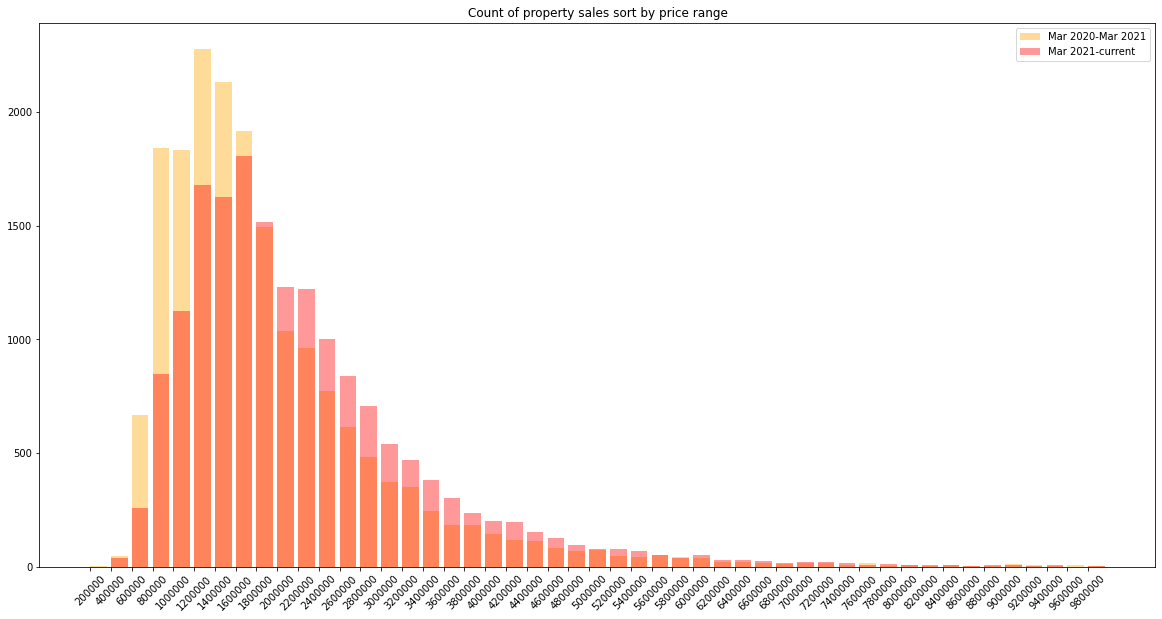

In [15]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
tag_2021 = df_plt_1['price_tag'].astype(str)
count_2021 = df_plt_1['count']
tag_2020 = df_plt_2['price_tag'].astype(str)
count_2020 = df_plt_2['count']

barwidth = 0.8
alpha = 0.4

plt.bar(tag_2020,count_2020,barwidth,align='edge', alpha=alpha, label = 'Mar 2020-Mar 2021', color = 'orange')
plt.bar(tag_2021,count_2021, barwidth, align='edge', alpha=alpha, label = 'Mar 2021-current', color = 'red')

plt.title('Count of property sales sort by price range')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

##### 1. properties sold under 1,600,000 has droped significantly.
##### 2. Nevertheless there are still a large amount of properties priced under my clients' budget.

## Location correlationship(to cbd) <a class="anchor" id="Location-correlationship"></a>

##### The house price has a less obvious correlation when not considering the land size.
##### In this analysis, I divide each house price to its land size as price per square meter.
##### To find its correlation to distance to CBD, PolynomialFeatures and LinearRegression will be used to perform modelling.

In [287]:
df_train_2021 = sqldf('''
WITH enriched AS(
    SELECT price
         , price_square
         , suburb
         , to_cbd
         , CASE WHEN sold_date > '2020-03-30' THEN 'since'
                WHEN sold_date < '2020-03-31' THEN 'before'
           END AS to_train_cat
      FROM df
     WHERE price_square>0 
       AND to_cbd < 30
       AND (category = 'detached_house' OR category = 'shared_wall')
       
       
)
SELECT suburb
     , price_square AS price
     , to_cbd
     , to_train_cat
  FROM enriched
 ORDER BY to_cbd DESC
''')
print(df_train_2021.head)

<bound method NDFrame.head of                 suburb    price     to_cbd to_train_cat
0          CASTLE HILL   3083.0  29.999007        since
1      BEROWRA HEIGHTS   1930.0  29.997956       before
2            FAIRFIELD   1219.0  29.997076       before
3           GREYSTANES   1599.0  29.997069        since
4           SMITHFIELD    823.0  29.996959       before
...                ...      ...        ...          ...
48074     DARLINGHURST  15123.0   0.946122       before
48075     DARLINGHURST  30392.0   0.945472        since
48076     DARLINGHURST  32051.0   0.943417        since
48077     DARLINGHURST  26389.0   0.904603        since
48078     DARLINGHURST  20732.0   0.887679        since

[48079 rows x 4 columns]>


In [246]:
df_train_2021 = df_train_2021.sort_values(by = ['to_cbd'])

In [247]:
price_since = df_train_2021['price'].where(df_train_2021['to_train_cat']=='since')
price_before = df_train_2021['price'].where(df_train_2021['to_train_cat']=='before')
cbd_since = df_train_2021['to_cbd'].where(df_train_2021['to_train_cat']=='since')
cbd_before = df_train_2021['to_cbd'].where(df_train_2021['to_train_cat']=='before')



In [248]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

In [249]:
cbd_since = cbd_since.to_numpy()
price_since= price_since.to_numpy()
cbd_before = cbd_before.to_numpy()
price_before= price_before.to_numpy()

In [250]:
cbd_since = cbd_since[~np.isnan(cbd_since)]
price_since = price_since[~np.isnan(price_since)]

price_since = np.reshape(price_since, (len(cbd_since),1))
cbd_since = np.reshape(cbd_since, (len(price_since),1))
print(cbd_since.shape)
print(price_since.shape)

(28078, 1)
(28078, 1)


In [251]:
cbd_before = cbd_before[~np.isnan(cbd_before)]
price_before = price_before[~np.isnan(price_before)]
price_before = np.reshape(price_before, (len(price_before),1))
cbd_before = np.reshape(cbd_before,(len(cbd_before),1))
print(cbd_before.shape)
print(price_before.shape)

(19970, 1)
(19970, 1)


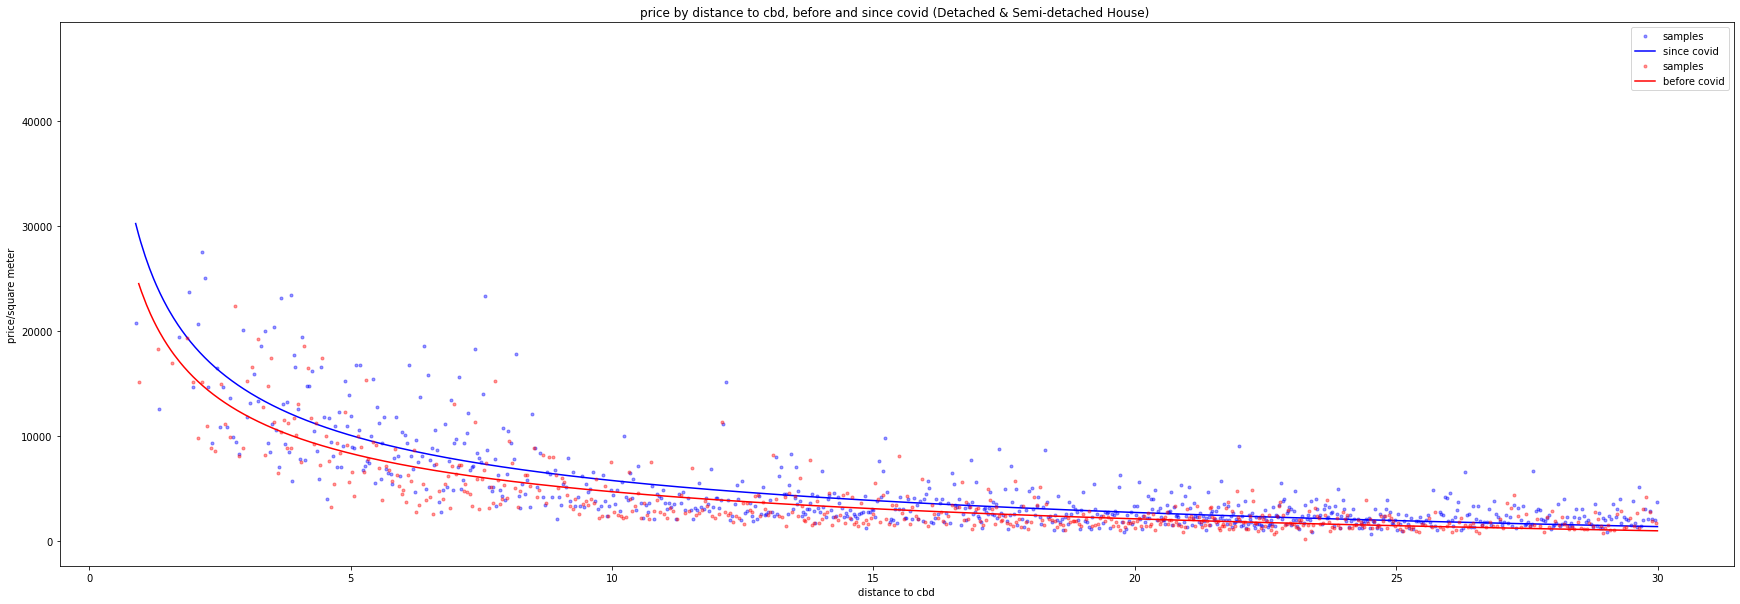

In [286]:
alpha = 0.4
cbd_since_poly = 1/(np.sqrt(cbd_since))
cbd_before_poly = 1/(np.sqrt(cbd_before))

model = LinearRegression()
model.fit(cbd_since, price_since)
plt.plot(cbd_since, price_since,'b.',label = 'samples', alpha = alpha, markevery=35)
poly = PolynomialFeatures(1)
poly_cbd_since = poly.fit_transform(cbd_since_poly)
model = LinearRegression()
model.fit(poly_cbd_since, price_since)
plt.plot(cbd_since, model.predict(poly.fit_transform(cbd_since_poly)), 'b', label = 'since covid')

model = LinearRegression()
model.fit(cbd_before, price_before)
plt.plot(cbd_before, price_before,'r.',label = 'samples', alpha = alpha, markevery=35)
poly = PolynomialFeatures(1)
poly_cbd_before = poly.fit_transform(cbd_before_poly)
model = LinearRegression()
model.fit(poly_cbd_before, price_before)
plt.plot(cbd_before, model.predict(poly.fit_transform(cbd_before_poly)), 'r', label = 'before covid')
plt.title('price by distance to cbd, before and since covid (Detached & Semi-detached House) ')
plt.xlabel('distance to cbd')
plt.ylabel('price/square meter')
plt.legend()

plt.show()

##### Price per square meter for detached & semi-detached houses increasing with the decrease of distance to CBD. And climbing even faster when close to CBD.

## So which suburbs should we target? <a class="anchor" id="So-which-suburbs-should-we-target?"></a>

##### With a budget of 1.6million, my client wants to buy a single family home with at least 4 bedrooms 2 baths and 2 parkings. And she wants to have it as close to CBD as possible.
##### I filled the data by limit records to the recent two quarters. So the result has stronger correlationship with current market.

In [316]:
df_home = sqldf('''

SELECT COUNT(*) AS count
     , suburb
     , postcode
     , AVG(to_cbd) AS distance
  FROM df
 WHERE sold_date > '2021-09-30'
   AND beds >= 4
   AND baths >=2
   AND parking >=2
   AND category = 'detached_house'
   AND price <= 1600000
 GROUP BY suburb
 ORDER BY distance


''')
df_home.head(20)

,count,suburb,postcode,distance
0,1,TURRELLA,2205,9.456560
1,2,BANKSIA,2216,10.577908
2,1,CANTERBURY,2193,11.772732
3,1,ROCKDALE,2216,12.205708
4,2,CAMPSIE,2194,12.794751
5,2,STRATHFIELD SOUTH,2136,13.145604
6,2,BEXLEY,2207,13.641403
7,1,BEVERLEY PARK,2217,13.990004
8,1,CARLTON,2218,14.189757
9,1,BELFIELD,2191,14.503208


![march-current](https://i.ibb.co/wKQrdV9/final.png)

## Conclusion <a class="anchor" id="Conclusion"></a>
##### Although the sold price from source web has increased significantly, there are still a lot of opportunities to find a single-family home for under 1.6 million in suburbs that are 10 km away from Sydney CBD.
##### The suggestion would be starting from suburbs relatively close to the city from southern suburbs like Rockdale and Banksi to inner west suburbs such as Strathfield South.
##### If it has been found that the price has been growing even higher in the last few months. Then we should also consider suburbs like Roselands and Greenacre.